# Assignment 02     
## CSCI S-96    

> **Instructions:** For this assignment you will complete the exercises shown. All exercises involve creating and executing some Python code. Additionally, most exercises have questions for you to answer. You can answer questions by creating a Markdown cell and writing your answer. If you are not familiar with Markdown, you can find a brief tutorial [here](https://www.markdownguide.org/cheat-sheet/).   

In this assignment you will work with some basic streaming analytic algorithms. To avoid the complexities of installing and setting up a real streaming analytics platform,you will work with stream flow data loaded from local files. Specifically in this assignment you will:    
1. Create and apply code to perform basic stream queries.    
2. Using stream queries and plots, explore the stream data.    
3. Use moving windows to compute moving averages and sub-sample a stream.    
4. Use exponential decay filters to compute moving averages and sub-sample a stream.    

## Overview 

The United States Geological Survey (USGS) maintains over 13,500 stream flow gages in the United States. Measurements from most of these gages are recoded every 15 min and uploaded every 4 hours are [available for download](https://waterdata.usgs.gov/nwis/rt). Stream flow data are used as inputs for complex water management tasks for purposes such as agriculture, residential use and conservation. For this assignment you will work with the time series of measurements for two stream flow gages on tributaries of the the Columbia River in the US State of Washington.     

To get started, execute the code in the cell below to import the packages you will need. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

## Loading the Dataset  

The next step is to load the stream gage data. The code in the cell below loads the time series data for the first gage. This gage is sited on the Okanogan river.  

The code in the cell below does the following:  
1. Loads the data from a .csv file. 
2. Converts the time stamp column to an index of the Pandas data frame. 
3. Assigns human-understandable names to the columns.  
4. Returns just the first 4 columns of the data frame. 

Execute this code and examine the results.

In [3]:
def read_index_series(file_name):  
    df = pd.read_csv(file_name, sep='\t')
    df.index = df.datetime
    df.drop('datetime', axis=1, inplace=True)
    df = df.iloc[:,:4]
    df.columns = ['Agency', 'Site_number', 'Time_zone', 'Stream_flow']
    return df.iloc[:,:4]

Malott = read_index_series('../data/12447200_Okanogan_at_Malott.txt')
Malott

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
2020-03-01 00:45,USGS,12447200,PST,2050
2020-03-01 01:00,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 22:45,USGS,12447200,PDT,1350
2020-08-31 23:00,USGS,12447200,PDT,1350
2020-08-31 23:15,USGS,12447200,PDT,1350


The other time series is for a gage on the Yakima River. Execute the code in the cell below and examine the result. 

In [4]:
CleElm = read_index_series('../data/12479500_Yakima_At_CleElm.txt')
CleElm

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:30,USGS,12484500,PST,1620
2020-03-01 00:45,USGS,12484500,PST,1620
2020-03-01 01:00,USGS,12484500,PST,1620
...,...,...,...,...
2020-08-31 22:45,USGS,12484500,PDT,3140
2020-08-31 23:00,USGS,12484500,PDT,3140
2020-08-31 23:15,USGS,12484500,PDT,3140


Since we really only want to work with one data frame. The code in the cell below merges the two time series and sorts them into time index order. Execute this code and examine the result, paying attention to the site number and the datetime index.  

In [5]:
stream_flow = Malott.append(CleElm).sort_index()
stream_flow

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 23:15,USGS,12447200,PDT,1350
2020-08-31 23:30,USGS,12484500,PDT,3140
2020-08-31 23:30,USGS,12447200,PDT,1350


## Querying Stream Data

Common stream data operations are often formulated as queries on the stream data. Many streaming data platforms use extensions of SQL for these queries.   

To keep things simple in this assignment we will just use a simple query function. The function shown in the cell below supports simple queries on the    

In [6]:
def query_stream(df, Columns=None, site_numbers=None, start_time=None, end_time=None):    
    '''
    Function to query the stream gage time series data. The arguments are:    
    df = the data frame containing the data.  
    Columns = a list of columns to return.   
    site_numbers = a list of gage site numbers to return. 
    start_time = the start time of the returned data.   
    end_time = the end time of the returned data.
    '''
    ## First set values for arguments set to Null  
    if Columns==None: Columns = df.columns
    if start_time==None: start_time = df.index[0]
    if end_time==None: end_time = df.index[df.shape[0]-1]
    if site_numbers==None: site_numbers = df.Site_number.unique()
    ## Test if index is a string datetime or an integer
    ## use iloc method if an integer.
    ## A slice over the time range is created based on the index type. 
    if isinstance(start_time, str):
        df = df.loc[start_time:end_time,:]
    else:     
        df = df.iloc[start_time:end_time,:]
    df = df.loc[df.Site_number.isin(site_numbers), Columns]
    ## Return the results of the query
    return df


You can see the options to run `query_stream` function by executing the code in the cell below. 

In [7]:
print(query_stream.__doc__)


    Function to query the stream gage time series data. The arguments are:    
    df = the data frame containing the data.  
    Columns = a list of columns to return.   
    site_numbers = a list of gage site numbers to return. 
    start_time = the start time of the returned data.   
    end_time = the end time of the returned data.
    


An example of using the query function is shown in the cell below. Execute this code and examine the result. 

In [8]:
len(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))
#q_s = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500])
# We are dealing with a Series
#print(q_s.head())
#q_s_arr = np.array(q_s)

17660

> **Exercise 02-01:** Using the `query_stream` function, write and execute the code in the cell below to compute and display the mean `Stream_flow`for the month of April of 2020 of site 1248500. Use the [Pandas.DataFrame.mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) method to compute the mean. Notice that using this approach we can compute most any statistic of interest on the query result.    

In [9]:

df1 =query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500], start_time='2020-04-01 00:00', end_time='2020-04-30 11:59').mean()
print('The mean for the Stream Flow for the month of April, 2020 for site 1248500 is: ' + str(df1))

The mean for the Stream Flow for the month of April, 2020 for site 1248500 is: 2238.241525423729


## Plotting Streaming Data

Visualization is important tool in data exploration and discovery. Numerical stream data is ideal for visual exploration if it can be subsampled to manageable size.  

The function in the cell below creates a time series plot. The time index of the Pandas data frame is used to generate the x-axis values. Execute the code in this cell to load this function.

In [10]:
def plot_time_series(df, ax=None): 
    if ax==None: fig, ax = plt.subplots(figsize=(20, 6))
    df.plot(ax=ax);
    ax.set_xlabel('Date');
    plt.show()
    return ax    

The code in the cell below creates time series plots of the stream flow data. The flow time series for two stream gages queried as arguments to the plot function. Execute this code and examine the results. 

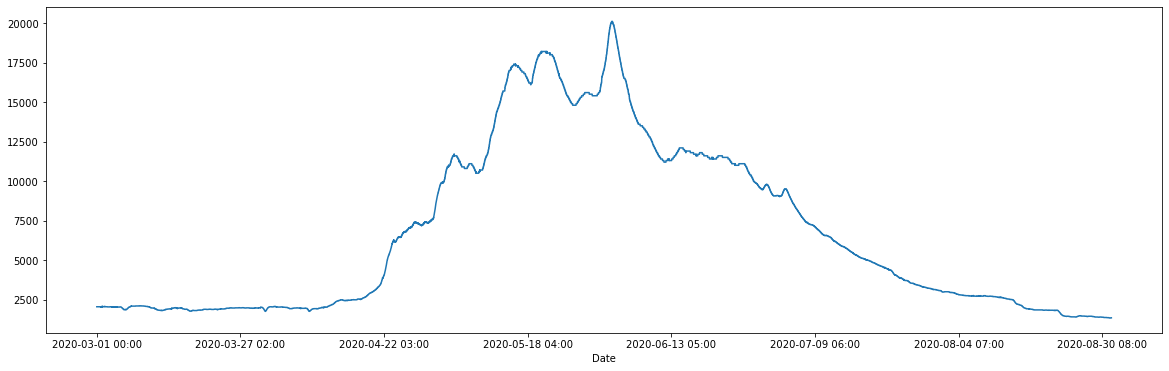

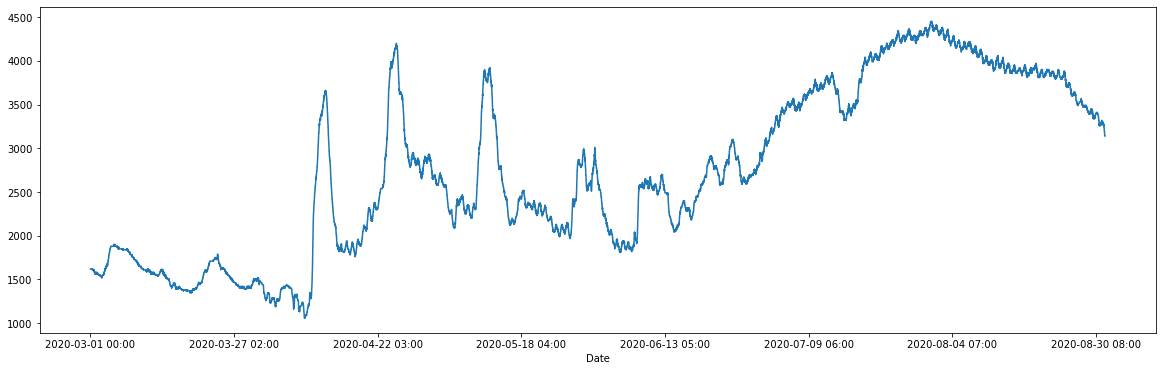

In [11]:
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200])) 
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))    

The time series of stream flow at both of these gages is rather complex. Both rivers have several dams used to control the flow. The flow is optimized to conserve fisheries and to supply agriculture in the Columbia River Basin. Water in reservoirs accumulates in the spring as mountain snow melts. The water is then is released throughout the spring and summer. 

But, what can we make of the noticeable spikes in flow, particularly for gage $12484500$ on the Yakima River. Even with the control provided by dams and reservoirs spring and early summer storm events can cause temporary increases in water flow. These storms bring heavy, and often warm, rain. Flow in the rivers increases not only because of the rainfall, but also since warm rain accelerates snow melt in the higher elevations.   

> **Exercise 02-02:** The transitory flow events on the Yakima River warrant some further investigation. You now have the tools to query and plot the stream flow time series. Your goal is to determine if there are common properties (e.g. duration or amplitude) of these events. Plot the results of a query for stream flows on gage $12484500$, Yakima River, from the 6th day of April to the 20th day of June, 2020. Discuss any common pattern in terms of approximately common amplitudes or durations of these events you can see.     

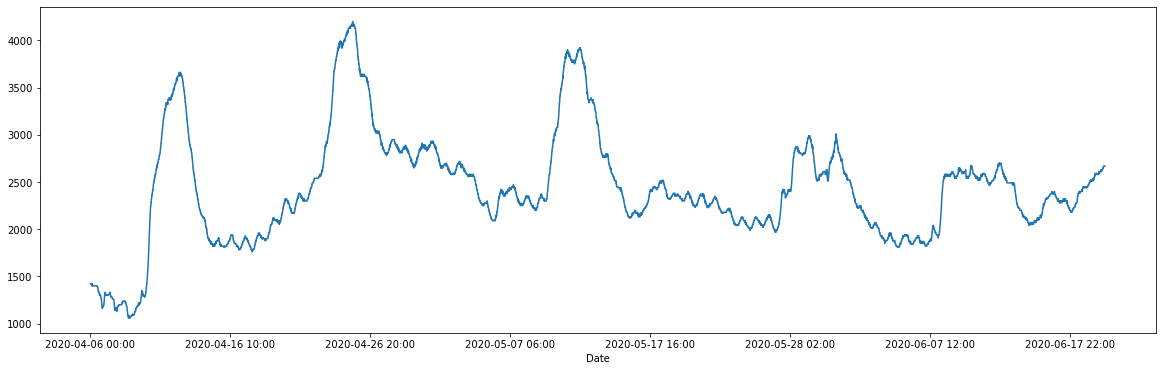

In [12]:
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500], start_time='2020-04-06 00:00', end_time='2020-06-20 11:59'))    

ANSWER: Exercis 02-02: From the plot time series above we see there is a series of tides and ebbs. It seems there are 5 in this time frame. Similar in nature and increases from the first one but deprecates in time from then on. There is an initial surge, then immediate ebb and then slow rise. We might be seeing 5 rainfalls of differing magnitudes. The first three being dominant. The last two being less so. But the overall line, if we tried to regress the plot, would be a slow rise from around 1500 to 2300 and this might be due to the snow melt.

## Applying Moving Window Filters

Moving window filters are a commonly used method to compute statistical samples from streaming data. 

Apply a moving window filter. 

> **Exercise 02-03:** You will complete and test the function in the cell below. The function queries a time series to create overlapping windows of a specified length and stride. For each window the mean of the stream flow is computed. The function returns a [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object. The time index of the Series object is the mid-point index of the window used to compute the statistic. 
> 1. Use a `for` loop to create the overlapping moving window samples of the input. The window will use the `length` and `stride` arguments to the function. At each iteration, the window will advance by `stride` time steps. See the [tutorial on the Python range function](https://www.w3schools.com/python/ref_func_range.asp) for help.    
>   - Query the input stream data for the stream flow values in the window. The `query_stream` function will accept integer indices for the `start_time` and `end_time` arguments. Make sure the these indicies are within the range of the original time series.  
>   - Append the mean of the stream flow values in the window to the `out` list.
>   - Append the time index of the midpoint of the window to the `idx` list.  
> 2. Once the loop has terminated used the [Pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) constructor to instantiate the return series. 

In [115]:


def window_average(ts, length=16, stride=8, Columns='Stream_flow', site_numbers=[12484500]):
# for 2 overlapping windows: 2 windows in a length

    from datetime import datetime
    half_stride = int(length/2)-1
    idx = []
    out = []
    fmt='%Y-%m-%d %H:%M'
## Put your code below
    ts_len = len(ts)
    print('ts_len ' + str(ts_len))
    print(ts.index[0])
    strstartA = ts.index[0]
    startA = datetime.strptime(strstartA, fmt)
    startA1 = pd.to_datetime(startA)
    inc = -1
    stride = length
    istride = inc * stride
    indstride = (stride * inc)
    strendA = ts.index[indstride]
    h_stride = int(length/2)
    ind_h_stride = int(indstride + h_stride)
    if ts_len >= 12:
        for i in range(0,ts_len-stride, stride):
            
            #endA = startA1 + stride
            inc += 1
            indstride = (stride * inc)-1
            h_stride = int(stride/2)
            # start the A's              
            ind_A_start = (stride * inc)
            ind_A_mid = int(ind_A_start + h_stride)
            ind_A_end = ind_A_start + stride-1
            startA = ts.index[ind_A_start]
            midA = ts.index[ind_A_mid]
            idx.append(midA)
            endA = ts.index[ind_A_end]
            #print( ind_A_start, ind_A_mid, ind_A_end)
            # Start the B's
            ind_B_start = (stride * inc)+ h_stride
            ind_B_mid = int(ind_B_start + h_stride)
            ind_B_end = ind_B_start + (stride)-1
            startB = ts.index[ind_B_start]
            midB = ts.index[ind_B_mid]
            idx.append(midB)
            endB = ts.index[ind_B_end]
            #print( ind_B_start, ind_B_mid, ind_B_end)
            #query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500], start_time='2020-04-06 00:00', end_time='2020-06-20 11:59')
            ts_A = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200], start_time= startA, end_time= endA)
            ts_B = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200], start_time= startB, end_time= endB)
            meanA = np.mean(ts_A)
            out.append(meanA)
            
            meanB = np.mean(ts_B)
            out.append(meanB)
            
            #print(' MEAN A: '+ str(meanA))
    #midA = 
    print('OUT.LEN = ' + str(len(out)))
    out = pd.Series(out, index=idx)  
    
    return out   


> 3. Next you will test your function by completing and executing the code in the cell below. Use your `window_average` function to create a Pandas Series with 4-hour stream flow averages (length of 16 time steps), taken every 2 hours (stride of 8 time steps). Name your Series filtered_12 and compute and print the length. The code provided queries the data so that you are working with only values from the Yakima River gage. Using flow rate values from only one gage simplifies the bookkeeping for window sampling. 

ts_len 17660
2020-03-01 00:00
OUT.LEN = 2206
2020-03-01 02:00    2050.0
2020-03-01 04:00    2050.0
2020-03-01 06:00    2050.0
2020-03-01 08:00    2050.0
2020-03-01 10:00    2050.0
dtype: float64
The length of filtered_12 is: 2206


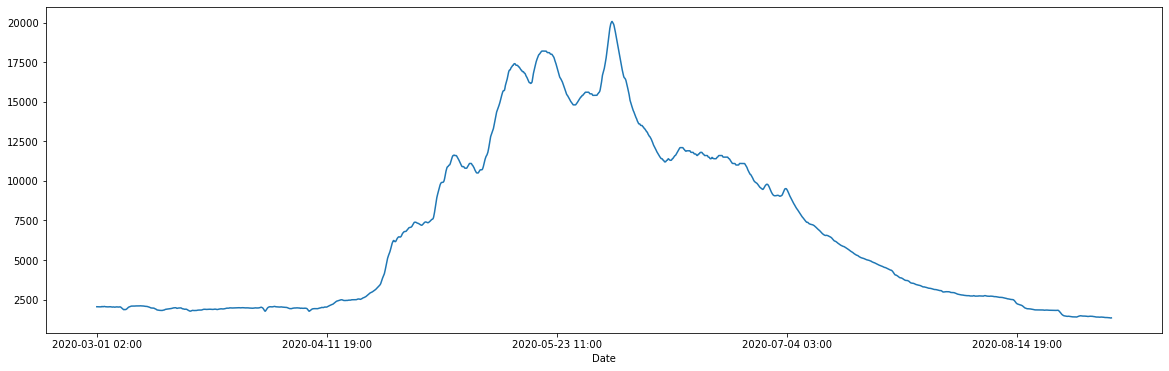

In [121]:
## Query to create a series with only the Yakima River stream gage data. 
## Put your code below
ts_1 = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200])
#def window_average(ts, length=16, stride=8, Columns='Stream_flow', site_numbers=[12484500]):
filtered_12 = window_average(ts_1, length = 16, stride = 8, Columns = 'Stream_flow', site_numbers =[12484500])
print(filtered_12.head())
print('The length of filtered_12 is: ' + str(len(filtered_12)))
_=plot_time_series(filtered_12) 

> 4. Notice how the length of the time series has been significantly reduced. Is the reduction the length of the time series consistent with a stride of 8 time steps?   
> **End of Exercise.**

To examine the 4-hour moving average time series you have computed, execute the code in the cell below. 

ANSWER: 4. Yes it is consistant with a stride of 8 time steps. In the example the total length of 
the time step file is 17660.  17660/ 8 is 2206, the length of the 4 hour moving average time series computed.
Done in the cell above

In [ ]:
## Query to create a series with only the Yakima River stream gage data. 
## Put your code below
ts_1 = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200])
#def window_average(ts, length=16, stride=8, Columns='Stream_flow', site_numbers=[12484500]):
filtered_12 = window_average(ts_1, length = 16, stride = 8, Columns = 'Stream_flow', site_numbers =[12484500])
print(filtered_12.head())
print('The length of filtered_12 is: ' + str(len(filtered_12)))

> **Exercise 02-4:** You will compute and display a time series using a longer, 1-day (96 time steps) moving window with a stride of 1/2 of a day (48 time steps). For this exercise, do the following:   
> 1. Query the Yakima River stream gage data with the longer time window and stride. 
> 2. Print the length of the resulting Pandas Series.  
> 3. Plot the moving average series.  

ts_len 17660
2020-03-01 00:00
OUT.LEN = 366
2020-03-01 12:00    2047.500000
2020-03-02 00:00    2052.916667
2020-03-02 12:00    2054.687500
2020-03-03 00:00    2045.416667
2020-03-03 12:00    2040.312500
dtype: float64


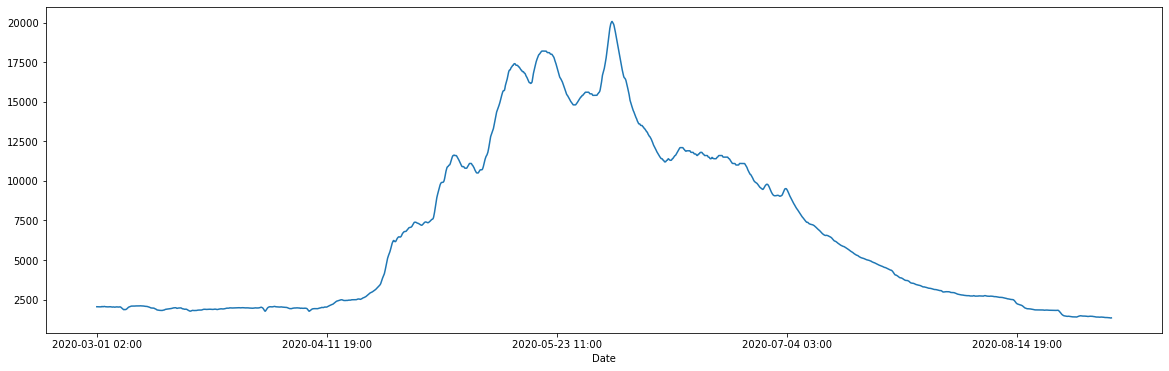

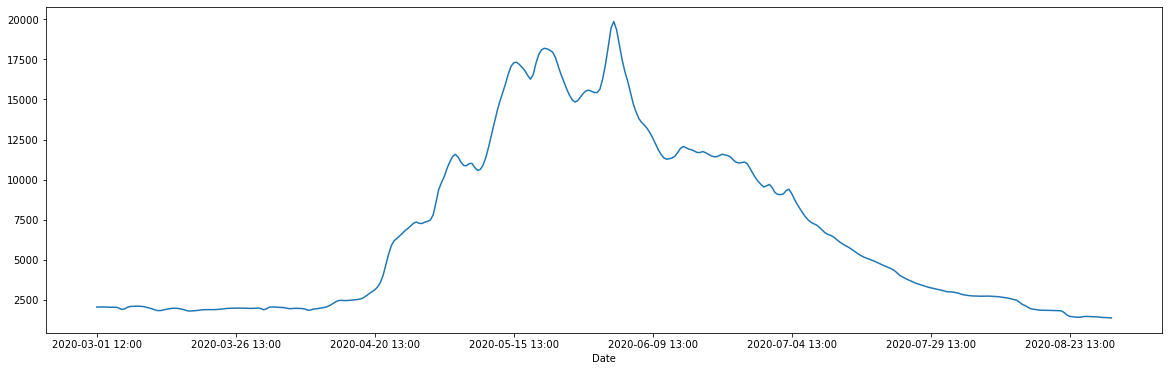

In [122]:
## Put your code below
ts_1 = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200])

# for 96 time steps/ 8 * 12 sstride 1/2 day; overlapping windows: 2 windows in a length
filtered_96 = window_average(ts_1, length = 96, stride = 48, Columns = 'Stream_flow', site_numbers =[12484500])
print(filtered_96.head())

_=plot_time_series(filtered_12) 
_=plot_time_series(filtered_96) 

> Answer the following questions:   
> A. What is the data compression ratio of the longer time window? Is this consistent with the stride of the window?   
> B. Compare the plots of the results of the two moving window summaries. What are the obvious differences? If the goal is to measure total volume of water passing the gage on a daily and weekly basis, does the series from the longer filter contain sufficient detail? 

ANSWER A. The data compression ratio is ~17660/48 = 367.92 which is around the length of this output = 366
Yes. this is consistant with the stride of the window which is 48

ANSWER B. The Plots are consistant with each other. But the Plot(filtered_96) is a little smoother. If we measure the total
volume as the flow under each of the function plots, we can visualize a similarity and eye balling it it is extremely close.

## Exponential Decay Filters

The idea of using exponential smooth for time series analysis is an old one, dating at least to use by Weiner in the 1920s. The related idea of moving average filters was developed by Kolmogorov and Zurbenko in the 1940s. Exponential smoothers were used extensively in signal process in the 1940s. The general idea was expanded by Robert Goodell Brown (1956) and C.E. Holt (1957) and his student P.R. Winters (1960). The higher-order Holt-Winters model accounts for trend and seasonality of time series.

### Basic exponential Smoothing

Exponential smoothing uses a weighted sum of the current observation and the past smoothed value to compute a new smoothed value. This basic exponential smoothing relationship is shown below.  

$$
s_0 = x_0 \\
s_t = \alpha x_t + (1-\alpha) s_{t-1} = s_{t-1} \alpha(x_t - s_{t-1}),\ t \gt 0
$$

The smoothing hyperparameter, $\alpha$, controls the trade-off between the last observation and the previous smoothed values. The possible values are in the range, $0 \le \alpha \le 1$. A large value of $\alpha$ puts more weight on the current observation. Whereas, a small value of $\alpha$ puts more weight on the smoothed history.      

How can we understand the exponential decay of the smoothed history of a time series. The smoothing hyperparameter, $\alpha$, an be expressed in terms of the decay constant, $\tau$ and time interval $\delta T$ as shown below.  

$$
\alpha = 1 - e^{\big( \frac{- \Delta T}{\tau} \big)}
$$

From this relationship you can see that the influence of the smoothed history decays exponentially as $\delta T$ increases. The decay time increases as $\tau$ decreases.   

### Smoothing with higher-order terms   

The basic exponential smoothing algorithm is effective in many cases. However, the simple first order exponential smoothing method cannot accommodate time series with trend or seasonality. Higher order smoothing models are required.   

The **double exponential smoothing** or **Holt-Winters double exponential smoothing** algorithm is a second order smoothing method. Using two coupled difference equations a trend and non-seasonal component of the time series can be modeled. The model updates a smoothed measure of the non-seasonal component and the trend.   

The model is initialized with the values:   
$$
s_1 = x_1 \\
b_1 = x_2 - x_1
$$

At each time step the a pair of time difference equations are updated. The following relationships update the smoothed non-seasonal component, $s_t$, and the slope, $b_t$:   

$$
s_t = \alpha x_t + (1-\alpha) (s_{t-1} + b_{t-1}) \\
b_t = \beta(s_t - s_{t-1}) + (1 - \beta)b_{t-1}
$$

The smoothed non-seasonal component and smoothed slope can be used to compute a forecast. The relationship below computes the forecast $m$ time steps ahead.      

$$ F_{t+m} = s_t + m b_t $$   

What about seasonal components? A third-order difference relationship can updated a smoothed seasonal component, along with the smoothed non-seasonal and slope components. The details of this process are not discussed further here. The details are available elsewhere, including the [exponential smoothing Wikipedia page](https://en.wikipedia.org/wiki/Exponential_smoothing#:~:text=Exponential%20smoothing%20is%20a%20rule,exponentially%20decreasing%20weights%20over%20time.).  

### Example of Exponential Decay Filtering     

> **Exercise 02-5:** You will now create and test an exponentially weighted decay filter. This function will have a stride argument just as the window filter function. Your function, `exponential_smooth`, will have arguments of the time series, the exponential smoothing parameter and a stride. Your function will do the following:    
> 1. Save the index of the incoming time series to a variable.   
> 2. Initialize the an empty index list for the output series.  
3. Initialize the value list for the samples. The samples list will contain the exponentially weighted smoothed samples. Make sure you save the first value in the list.   
> 4. Initialize an empty output value list.   
> 5. A for loop iterates over all the values of the time series starting with the second one. In this case a query is not used since for a live stream the exponential decay filter is updated each time a value arrives.    
>   - Append the computed exponentially weighted values smoothed values to the samples list. 
>   - If the loop index modulo the stride is 0 then, append the sample value to the output list and the index of that sample to the index list.  
> 8. Create an output Pandas Series from the output list and the output index list. 
> 9. Return the Pandas Series.  
> 10. Execute your function with for site number $12484500$ and default arguments of `alpha=0.01` and `stride=8`, 2 hours. 
> 11. Print the length the resulting series. 
> 12. Plot the series with the `plot_time_series` function. 

In [243]:
def exponential_smooth(ts, alpha=0.01, stride=8):
    
    half_stride = int(stride/2) -1

    modulo = stride
    inc_sample = 0
    out = []
    samples = []
    idx = []
    # start init values for index = 0
    s0 = ts[0]
    out.append(s0)
    samples.append(s0)
    idx.append(ts.index[0])
    inc_samples = 0
    # find length of ts
    ts_len = len(ts)
    # can only evaluate full_win_count =ts_len/stride amounts
    # so full_win_count is last full window 
    full_win_count = int(ts_len/stride)
    # last record evaluated is full_win_count * stride
    max_rec = full_win_count

    for i in range(1, max_rec, modulo):
    # this goes from 1 to last full_win_count step modulo

        # start with inc_samples = 0 from above loop
        
        if inc_samples >= modulo :
            # resets the inc_sample ( modulo) to zero
            inc_samples = 0
        if inc_samples = 0:
            out.append(s)
            idx.append(ts.index[i])
            
        print(inc_samples)
        inc_samples += 1
        
ts_1 = query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500])
#print(ts_1.head())
#filtered_12 = window_average(ts_1, length=16, stride=8, Columns='Stream_flow', site_numbers=[12484500])
#filtered_96 = window_average(ts_1, length = 16, stride = 8, Columns = 'Stream_flow', site_numbers =[12484500])
#print(filtered_12)
ex_sm = exponential_smooth(ts_1,alpha=0.01, stride=8)

#rint(ex_sm.head())
#print('The length of the resulting series is: ' + str(len(ex_sm)))

#_=plot_time_series(ex_sm) 

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


> Answer the following questions. Are the number of smoothed samples correct for the stride of the exponential decay filter selected? Are the details of the filtered time series substantially the same as the original series?  
> **End of exercise.** 

> **Exercise 02-6:** A question we should ask is what happens if you increase the smoothing constant of the exponential decay filter? In other words, what is the effect of giving greater weight to past values? To find out do the following:  
> 1. Execute the `exponential_smooth` function with arguments `alpha=0.99` and `stride=8`.
> 2. Print the length of the resulting Pandas Series. 
> 3. Plot the smoothed time series using the `plot_time_series` function. 

In [ ]:
## Put your code below




> Answer the following questions. Compare the plot of this time series to the previous series less smoothing. What is the main difference you can see?     
> **End of exercise.**

> **Exercise 02-7:** The next question to ask is what is the effect of changing the stride? A longer stride reduces the number of smoothed samples used for further processing. To find out do the following:  
> 1. Execute the `exponential_smooth` function with arguments `alpha=0.99` and `stride=96`, one day or 24 hours.
> 2. Print the length of the resulting Pandas Series. 
> 3. Plot the smoothed time series using the `plot_time_series` function. 

In [ ]:
## Put your code below




> Answer the following questions. Compare the plot of this time series to the previous series with a shorter stride. What is the main difference you can see? Do you think any difference is significant in terms of managing water flow on a daily or weekly basis? Finally, is the number of samples consistent with the stride defined?       
> **End of exercise.**

#### Copyright 2021 Stephen F Elston. All rights reserved. 